In [1]:
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

sc = SparkContext(master="local[*]", appName="Machine Learning in Tesla Auto Follow System")
spark = SparkSession(sparkContext=sc)

In [2]:
df = spark.read.csv('autopilot.csv', header=True, inferSchema=True)
df.show()

+------------+-----------+-----+-----+---------+---------+------------------------+
|Day_Or_Night|Cars_Around|Windy|Rainy|Position1|Position2|Is_Front_Car_Change_Lane|
+------------+-----------+-----+-----+---------+---------+------------------------+
|         Day|          3|   No|   No|      0.2|        1|                       1|
|       Night|          0|   No|   No|     -0.3|        0|                       0|
|         Day|          8|   No|   No|      0.4|      0.3|                       0|
|         Day|          3|  Yes|   No|     -0.5|     -1.5|                       1|
|       Night|          3|   No|   No|    -0.25|     Null|                       0|
|       Night|          0|  Yes|  Yes|      0.1|      0.1|                       0|
|       Night|          2|   No|  Yes|     0.25|      1.2|                       0|
|       Night|          3|   No|   No|      0.2|        1|                       1|
|       Night|          1|   No|  Yes|     -0.3|        0|                  

In [3]:
from pyspark.sql.functions import avg

average = df.select(avg('Position2')).head()[0]
df = df.na.replace('Null', str(average), 'Position2')
df.show()

+------------+-----------+-----+-----+---------+--------------------+------------------------+
|Day_Or_Night|Cars_Around|Windy|Rainy|Position1|           Position2|Is_Front_Car_Change_Lane|
+------------+-----------+-----+-----+---------+--------------------+------------------------+
|         Day|          3|   No|   No|      0.2|                   1|                       1|
|       Night|          0|   No|   No|     -0.3|                   0|                       0|
|         Day|          8|   No|   No|      0.4|                 0.3|                       0|
|         Day|          3|  Yes|   No|     -0.5|                -1.5|                       1|
|       Night|          3|   No|   No|    -0.25|-0.09904761904761904|                       0|
|       Night|          0|  Yes|  Yes|      0.1|                 0.1|                       0|
|       Night|          2|   No|  Yes|     0.25|                 1.2|                       0|
|       Night|          3|   No|   No|      0.2|  

In [4]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions


for col in df.columns:    
    data = df.select(functions.col(col).cast('double').isNotNull()).collect()
    
    #numerica
    if data[0][0]:
        #use withColumn to alternate original column with double version
        df = df.withColumn(col, functions.col(col).cast('double'))
        
    
    #non-numerica
    #use StringIndexer to fit non-numerica columns to numbers
    else:
        col_num = col+'_num'
        num_StringIndexer = StringIndexer(inputCol = col, outputCol = col_num)       
        model = num_StringIndexer.fit(df)       
        df = model.transform(df)        
        #drop the original non-numerica data
        df = df.drop(col)
        
df.show()

+-----------+---------+--------------------+------------------------+----------------+---------+---------+
|Cars_Around|Position1|           Position2|Is_Front_Car_Change_Lane|Day_Or_Night_num|Windy_num|Rainy_num|
+-----------+---------+--------------------+------------------------+----------------+---------+---------+
|        3.0|      0.2|                 1.0|                     1.0|             0.0|      0.0|      0.0|
|        0.0|     -0.3|                 0.0|                     0.0|             1.0|      0.0|      0.0|
|        8.0|      0.4|                 0.3|                     0.0|             0.0|      0.0|      0.0|
|        3.0|     -0.5|                -1.5|                     1.0|             0.0|      1.0|      0.0|
|        3.0|    -0.25|-0.09904761904761904|                     0.0|             1.0|      0.0|      0.0|
|        0.0|      0.1|                 0.1|                     0.0|             1.0|      1.0|      1.0|
|        2.0|     0.25|              

In [5]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

#exclude 'Is_Front_Car_Change_Lane' as column to test accuracy
inputCols = ['Cars_Around', 'Position1', 'Position2', 'Day_Or_Night_num', 'Windy_num', 'Rainy_num']
#create feature vector
vector_assembler = VectorAssembler(\
inputCols=inputCols,\
outputCol='features')

df_temp = vector_assembler.transform(df)
df_temp.show(3)

#remain just Is_Front_Car_Change_Lane and features columns
df = df_temp.select('Is_Front_Car_Change_Lane','features')
df.show(3)


(trainingData, testData) = df.randomSplit([0.7, 0.3], seed = 1996)

+-----------+---------+---------+------------------------+----------------+---------+---------+--------------------+
|Cars_Around|Position1|Position2|Is_Front_Car_Change_Lane|Day_Or_Night_num|Windy_num|Rainy_num|            features|
+-----------+---------+---------+------------------------+----------------+---------+---------+--------------------+
|        3.0|      0.2|      1.0|                     1.0|             0.0|      0.0|      0.0|[3.0,0.2,1.0,0.0,...|
|        0.0|     -0.3|      0.0|                     0.0|             1.0|      0.0|      0.0|(6,[1,3],[-0.3,1.0])|
|        8.0|      0.4|      0.3|                     0.0|             0.0|      0.0|      0.0|[8.0,0.4,0.3,0.0,...|
+-----------+---------+---------+------------------------+----------------+---------+---------+--------------------+
only showing top 3 rows

+------------------------+--------------------+
|Is_Front_Car_Change_Lane|            features|
+------------------------+--------------------+
|           

## DT

In [6]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(labelCol="Is_Front_Car_Change_Lane", featuresCol="features")
model = dt.fit(trainingData)

predictions = model.transform(testData)

predictions.select("prediction", "Is_Front_Car_Change_Lane").show(10)

evaluator = MulticlassClassificationEvaluator(\
labelCol="Is_Front_Car_Change_Lane", predictionCol="prediction",\
metricName="accuracy")

accuracy1 = evaluator.evaluate(predictions)

print("Accuracy = ", accuracy1)
print("Test Error = %g " % (1.0 - accuracy1))

+----------+------------------------+
|prediction|Is_Front_Car_Change_Lane|
+----------+------------------------+
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
+----------+------------------------+
only showing top 10 rows

Accuracy =  0.8888888888888888
Test Error = 0.111111 


## LR

In [7]:
from pyspark.ml.classification import LogisticRegression

# Create an initial model using the train set.
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Is_Front_Car_Change_Lane',    maxIter=10)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)
predictions.select("prediction", "Is_Front_Car_Change_Lane").show(10)

evaluator = MulticlassClassificationEvaluator(\

labelCol="Is_Front_Car_Change_Lane", predictionCol="prediction",\

metricName="accuracy")

accuracy2 = evaluator.evaluate(predictions)

print("Accuracy = ", accuracy2)
print("Test Error = %g " % (1.0 - accuracy2))

+----------+------------------------+
|prediction|Is_Front_Car_Change_Lane|
+----------+------------------------+
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       1.0|                     0.0|
|       1.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
+----------+------------------------+
only showing top 10 rows

Accuracy =  0.8888888888888888
Test Error = 0.111111 


## GBT

In [8]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol = 'features', labelCol = 'Is_Front_Car_Change_Lane', maxIter=10)
gbtModel = gbt.fit(trainingData)
predictions = gbtModel.transform(testData)
predictions.select("prediction", "Is_Front_Car_Change_Lane").show(10)

evaluator = MulticlassClassificationEvaluator(\

labelCol="Is_Front_Car_Change_Lane", predictionCol="prediction",\

metricName="accuracy")

accuracy3 = evaluator.evaluate(predictions)

print("Accuracy = ", accuracy3)
print("Test Error = %g " % (1.0 - accuracy3))

+----------+------------------------+
|prediction|Is_Front_Car_Change_Lane|
+----------+------------------------+
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       1.0|                     0.0|
|       1.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
|       0.0|                     0.0|
+----------+------------------------+
only showing top 10 rows

Accuracy =  0.9259259259259259
Test Error = 0.0740741 


You should consider upgrading via the 'pip install --upgrade pip' command.


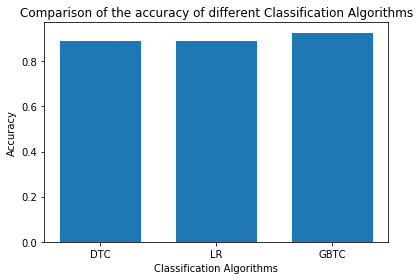

In [9]:
import numpy as np
!pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

x = ['DTC', 'LR', 'GBTC']
y = [accuracy1, accuracy2, accuracy3]


bar_width = 0.7

y_pos = np.arange(len(x))

plt.bar(y_pos, y, bar_width, align='center')
plt.xticks(y_pos, x)
plt.xlabel('Classification Algorithms')
plt.ylabel('Accuracy')
plt.title('Comparison of the accuracy of different Classification Algorithms')
plt.tight_layout()
plt.show()